# SEIRD fixed infectious rate

In [1]:
import os
import datetime

import pandas as pd
import numpy as np
np.random.seed(42)
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', font_scale=1.2)

In [2]:
# all data
DATA_DIR = 'data'
FILE_NAME = 'initial_timeseries_SEIRD.csv' 
FILE_PATH = os.path.join(os.pardir, DATA_DIR, FILE_NAME)
df = pd.read_csv(FILE_PATH)

# derived data
cum_positives = np.cumsum(df.confirmed_positives.values)
cum_deceased = np.cumsum(df.confirmed_deceased.values)

# training_data
I_train = cum_positives - df.estimate_recovered.values
R_train = df.estimate_recovered.values
D_train = cum_deceased

# initial conditions
S0 = I_train[-1] + R_train[-1] + D_train[-1]
E0 = 10
I0 = 1
R0 = 0
D0 = 0
ic = [S0, E0, I0, R0, D0]

# transmission rate
beta = 0.5

In [3]:
# loss fun
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# system of odes
def SEIRD_ode(t, y, delta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R + D
    return [
        -beta*S*I/N - delta*S*E, 
        beta*S*I/N - alpha*E + delta*S*E, 
        alpha*E - gamma*I - mu*I, 
        gamma*I,
        mu*I,
    ]

# model
class SEIRD_model(object):
    def __init__(self):
        pass
    
    def fit(
        self, 
        active_cases, 
        recovered_cases,
        death_cases,
        initial_conditions,
        initial_guess=[0.1, 0.1, 0.1, 0.1],
        ):
        self.active_cases = active_cases
        self.recovered_cases = recovered_cases
        self.death_cases = death_cases
        self.removed_cases = self.recovered_cases + self.death_cases
        loss = []
        def print_loss(p):
            loss.append(
                SEIRD_model._loss(
                    p, 
                    self.active_cases, 
                    self.recovered_cases,
                    self.death_cases,
                    initial_conditions,
                    )
            )
            
        self.y0 = initial_conditions
        opt = minimize(
            fun=SEIRD_model._loss, 
            x0=initial_guess,
            args=(self.active_cases, self.recovered_cases, self.death_cases,
                  self.y0),
            method='L-BFGS-B',
            bounds=[(1e-5, 1.0), (1e-5, 1.0), (1e-5, 1.0), (1e-5, 1.0),],
            options={'maxiter': 1000, 'disp': True},
            callback=print_loss,
        )
        self.delta, self.alpha, self.gamma, self.mu = opt.x
        return (self.delta, self.alpha, self.gamma, self.mu), loss

    def simulate(self):
        sol = solve_ivp(
            fun=SEIRD_ode, 
            t_span=(0, self.active_cases.size), 
            y0=self.y0, 
            args=(self.delta, self.alpha, self.gamma, self.mu),
            method='RK45', 
            t_eval=np.arange(0, self.active_cases.size, 1), 
            vectorized=True,
        )
        return (sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4])
    
    @staticmethod
    def _loss(params, active_cases, recovered_cases, death_cases, 
              initial_conditions):
        size = active_cases.size
        sol = solve_ivp(
            fun=SEIRD_ode, 
            t_span=(0, size), 
            y0=initial_conditions, 
            args=params,
            method='RK45', 
            t_eval=np.arange(0, size, 1), 
            vectorized=True,
        )
        return mse(sol.y[2], active_cases) \
               + mse(sol.y[3], recovered_cases) \
               + mse(sol.y[4], death_cases)

In [4]:
model = SEIRD_model()

In [5]:
params, loss = model.fit(I_train, R_train, D_train, ic)

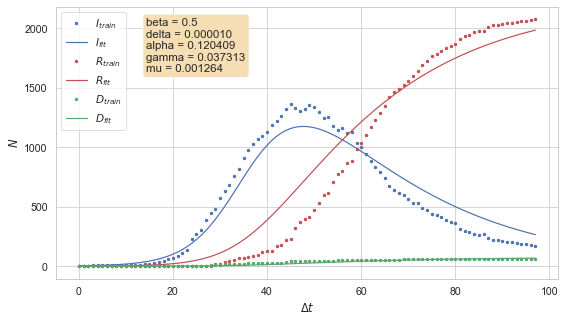

In [6]:
(S_sim, E_sim, I_sim, R_sim, D_sim) = model.simulate()
fig = plt.figure(figsize=(9, 5))
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(I_train, '.', c='b', label='$I_{train}$')
ax.plot(I_sim, '-', c='b', label='$I_{fit}$')
ax.fill_between(x=list(range(I_train.shape[0])), y1=I_sim[0], y2=I_sim[2], color='b', alpha=0.1)
ax.plot(R_train, '.', c='r', label='$R_{train}$')
ax.plot(R_sim, '-', c='r', label='$R_{fit}$')
ax.plot(D_train, '.', c='g', label='$D_{train}$')
ax.plot(D_sim, '-', c='g', label='$D_{fit}$')
ax.text(0.18, 0.96,
        f'beta = {beta}\ndelta = {params[0]:.6f}\nalpha = {params[1]:.6f}\ngamma = {params[2]:.6f}\nmu = {params[3]:.6f}', 
        transform=ax.transAxes,
        verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=1))
ax.set_xlabel('$\Delta t$')
ax.set_ylabel('$N$')
ax.legend()
plt.show();

In [7]:
# beta <= average number of contacts per person per time 
# alpha + gamma <= infectious rate = 1/(infectious time period)
# R0 <= basic reproduction number
R0 = beta / (params[1] + params[2])
R0

3.1701403427401784

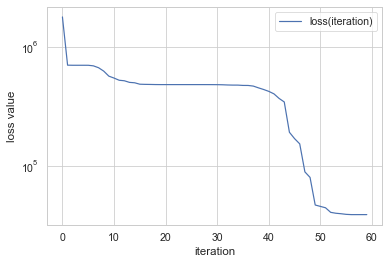

In [8]:
fig = plt.figure()
ax = fig.subplots()
ax.plot(loss, label='loss(iteration)')
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss value')
ax.legend()
plt.show();

In [9]:
df.columns

Index(['testing_date', 'total_tests', 'confirmed_positives',
       'confirmed_deceased', 'estimate_recovered'],
      dtype='object')

In [10]:
# uncertainty quantification
pcr_sens = 0.9
std_sens_err = np.sqrt(np.divide(
    (1 - pcr_sens) * pcr_sens, 
    df.confirmed_positives.values,
    out=np.zeros(df.confirmed_positives.values.shape, dtype=float), 
    where=df.confirmed_positives.values!=0,
))
sens_ci = 1.960 * std_sens_err
lb_sens = np.abs(pcr_sens - sens_ci)
lb_true_positives = lb_sens * df.confirmed_positives.values
lb_active = np.cumsum(lb_true_positives) - df.estimate_recovered.values  # ovdi je sranje, stavi 0 ako je <0
lb_active[np.where(lb_active<0)] = 0  # uzas
lb_scaler = lb_active / I_train

In [11]:
pcr_spec = 0.95
# yesterday's test gives today's result 
total_tests = np.concatenate((np.array([df.total_tests.values[0]]), df.total_tests.values[:-1]))
negatives = total_tests - df.confirmed_positives.values
std_spec_err = np.sqrt(np.divide(
    (1 - pcr_spec) * pcr_spec,
    negatives,
    out=np.zeros(negatives.shape, dtype=float), 
    where=negatives!=0,
))
spec_ci = 1.960 * std_spec_err
ub_specificity = np.abs(pcr_spec + spec_ci)
ub_true_negatives = ub_specificity * negatives
ub_false_negatives = negatives - ub_true_negatives
ub_true_positives = ub_false_negatives + df.confirmed_positives.values
ub_active = np.cumsum(ub_true_positives) - df.estimate_recovered.values
ub_scaler = ub_active / I_train
ub_scaler[np.where(ub_scaler<1)] = 1

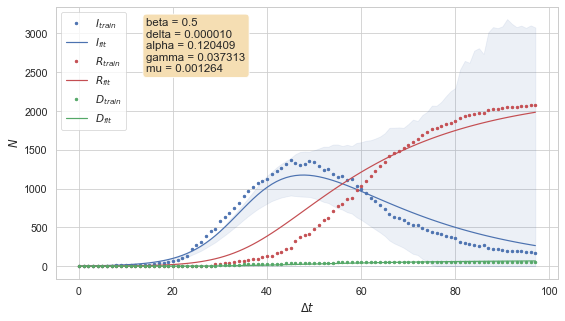

In [12]:
fig = plt.figure(figsize=(9, 5))
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(I_train, '.', c='b', label='$I_{train}$')
ax.plot(I_sim, '-', c='b', label='$I_{fit}$')
ax.fill_between(list(range(I_train.shape[0])), lb_scaler*I_sim, ub_scaler*I_sim, color='b', alpha=0.1)
ax.fill_between(x=list(range(I_train.shape[0])), y1=I_sim[0], y2=I_sim[2], color='b', alpha=0.1)
ax.plot(R_train, '.', c='r', label='$R_{train}$')
ax.plot(R_sim, '-', c='r', label='$R_{fit}$')
ax.plot(D_train, '.', c='g', label='$D_{train}$')
ax.plot(D_sim, '-', c='g', label='$D_{fit}$')
ax.text(0.18, 0.96,
        f'beta = {beta}\ndelta = {params[0]:.6f}\nalpha = {params[1]:.6f}\ngamma = {params[2]:.6f}\nmu = {params[3]:.6f}', 
        transform=ax.transAxes,
        verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=1))
ax.set_xlabel('$\Delta t$')
ax.set_ylabel('$N$')
ax.legend()
plt.show();